# Временные ряды

## 1. Линейная регрессия

### Условия Гаусса-Маркова

Мы можем использовать линейную регрессию для предсказания. Модель выглядит так:
$$y_i = kx_i + b + \epsilon_i$$
$$\epsilon_i \sim N(0, \sigma^2)$$

Здесь $\epsilon$ – белый шум, находящийся внутри $y$ и его нельзя объяснить с помощью $x$.

Есть набор правил (условий), при соблюдении которых (*всех*) мы можем гарантировать, что модель будет хорошо оценивать параметры распределения:  
* Параметр $k$ – линейный
* $x$ и $y$ – случайные переменные
* Признаки $x_i$ не коллинеарны между собой (то есть, не коррелируют между собой)
* $\epsilon$ – эндогенная переменная (endogenous). Это значит, что случайный шум не зависит от наших данных
* $\epsilon$ – гомоскедастичная переменная (homoscedastic). Это значит, что дисперсия шума не зависит от наших данных
* $\epsilon$ – переменная, не имеющая автокорреляции. Это значит, что между разными значениями шума нет корреляции

Есть небольшая проблема с этими условиями, когда мы говорим о временных рядах: мы получаем наши $x$ из одного процесса, так что это больше не случайная переменная. В случае в временными рядами мы ожидаем, что все $x_i$ детерминированы и не все равны между собой.

## 2. Тренд, сезонность

**Тренд** – системная линейная или нелинейная компенента во временном ряде, которая изменяется и не повторяется со временем. Например, линейный тренд или экспоненциальный тренд. 

**Сезонность** – системная линейная или (чаще) нелинейная компонента во временном ряде, которая изменяется и повторяется со временем. 

In [ ]:
import pandas as pd

import pandas as pd
import numpy as np
import plotly.graph_objs as go
import matplotlib.pyplot as plt

from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from statsmodels.tsa.seasonal import seasonal_decompose

%matplotlib inline

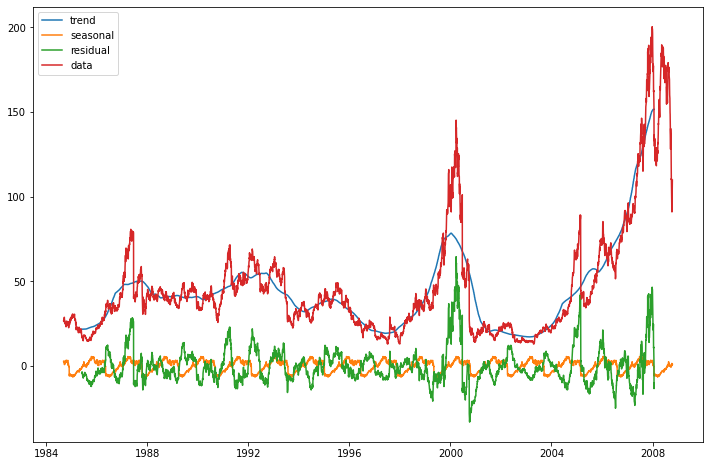

In [ ]:
df = pd.read_csv('aapl.csv', delimiter=',', usecols=['Date', 'Open', 'High', 'Low', 'Close'])
df.Date = pd.to_datetime(df.Date)
df['Mean'] = (df.High + df.Low ) / 2.0

decomposition = seasonal_decompose(df.Mean.values, period=365) 

plt.figure(figsize=(12, 8))
plt.plot(df.Date, decomposition.trend, label='trend')
plt.plot(df.Date, decomposition.seasonal, label='seasonal')
plt.plot(df.Date, decomposition.resid, label='residual')
plt.plot(df.Date, df['Mean'], label='data')
plt.legend();

In [ ]:
trace1 = go.Scatter(
    x = df.Date, y = decomposition.trend,
    name = 'Trend', mode='lines'
)
trace2 = go.Scatter(
    x = df.Date, y = decomposition.seasonal,
    name = 'Seasonal', mode='lines'
)
trace3 = go.Scatter(
    x = df.Date, y = decomposition.resid,
    name = 'Residual', mode='lines'
)
trace4 = go.Scatter(
    x = df.Date, y = df.Mean,
    name = 'Mean Stock Value', mode='lines'
)

data = [trace1, trace2, trace3, trace4]
plot(data);

**Бегущее среднее** – способ сглаживать данные.

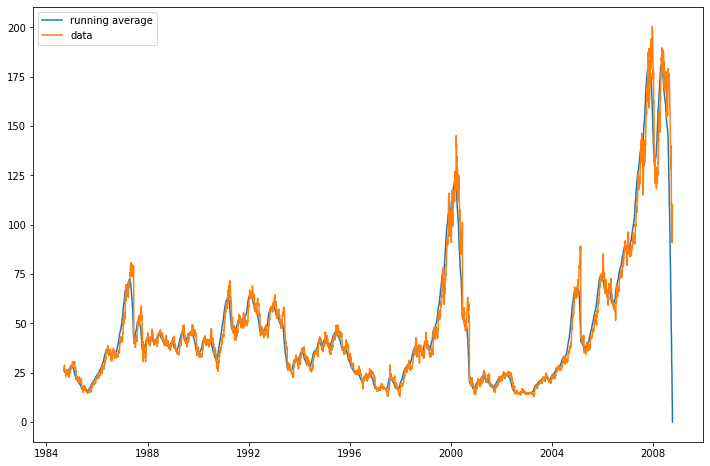

In [ ]:
running_mean = 0.0
run_avg_predictions = [running_mean]
decay = 0.95

for pred_idx in range(1, len(df.Mean)):
    running_mean = running_mean * decay + (1.0 - decay) * df.Mean[pred_idx - 1]
    run_avg_predictions.append(running_mean)

plt.figure(figsize=(12, 8))
plt.plot(df.Date, run_avg_predictions, label='running average')
plt.plot(df.Date, df['Mean'], label='data')
plt.legend();

## 3. Предсказание

Как мы делаем предсказания во временных рядах? Все логично: предсказываем следующие наблюдения по предыдущим.

### Авторегрессия

Авторегрессия – модель, которая принимает прошлые наблюдения в качестве входных данных для регрессионной модели, чтобы предсказывать следующее наблюдение.

In [ ]:
import warnings
from statsmodels.tsa.ar_model import AutoReg

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    
    window_size = 50
    ar_list = list(df.Mean[:window_size])
    for pred_idx in range(window_size, len(df.Mean)):

        current_window = list(df.Mean[pred_idx - window_size:pred_idx])
        model = AutoReg(current_window, [1, 4]).fit()
        current_predict = model.predict(50, 50)[0]
        ar_list.append(current_predict)

In [ ]:
ar_list_filtered = np.where(np.array(ar_list) > 1e5, 0, np.array(ar_list))

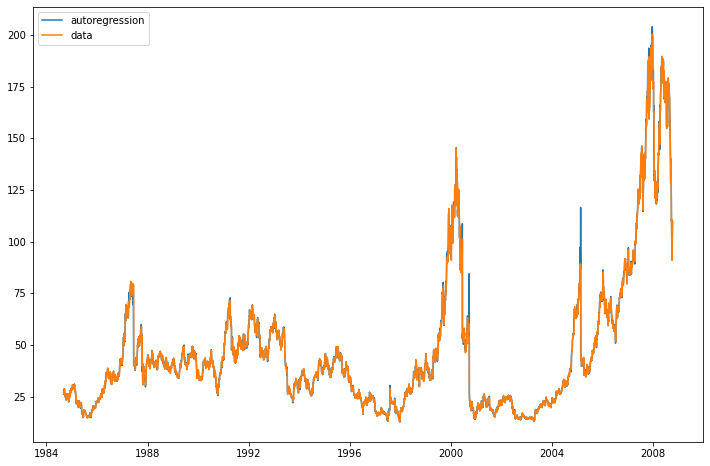

In [ ]:
plt.figure(figsize=(12, 8))
plt.plot(df.Date, ar_list, label='autoregression')
plt.plot(df.Date, df['Mean'], label='data')
plt.legend();

In [ ]:
trace5 = go.Scatter(
    x = df.Date, y = ar_list,
    name = 'Auto Regression', mode='lines'
)
plot([trace4, trace5]);

### ARMA

In [ ]:
from statsmodels.tsa.arima_process import ArmaProcess
simulated_ARMA_data = ArmaProcess()

Попробуем применить лог-трансформацию и возьмем разницу между соседними значениями, чтобы убрать тренд и изменение дисперсии. Такие данные будут называться стационарными.

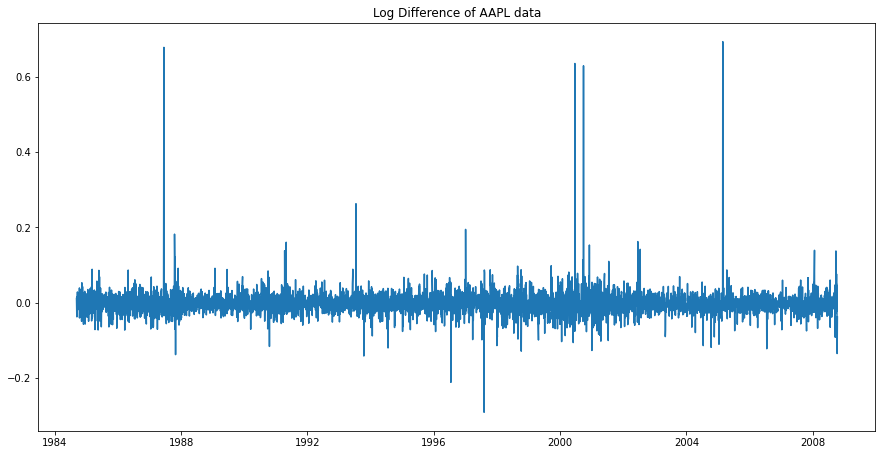

In [ ]:
stationary = np.log(df.Mean)
stationary = stationary.diff()
plt.figure(figsize=[15, 7.5])
plt.plot(df.Date, stationary)
plt.title("Log Difference of AAPL data")
plt.show()

Модель ARMA использует одновременно авторегрессию (новые значения зависят от предыдущих значений, параметр $p$) и бегущее среднее (новые значения зависят от шума на прошлых шагах, параметр $q$).  
Улучшение этой модели – ARIMA, которая также применяет разность между значениями, где параметр $d$ означает количество взятий разности для данных. Это позволяет добиться стационарности. 

Для выбора наиболее подходящих значений $p, d, q$ можно использовать Akaike’s Information Criterion или AIC (меньше – лучше).
$$AIC = -2 \log{L} + 2k$$
$L$ – likelihood данных (произведение плотностей вероятности при разных значениях параметров), $k$ – количество параметров.

In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima_model import ARIMA
from itertools import product
from tqdm import tqdm

In [ ]:
def optimize_ARIMA(order_list, exog):
    results = []
    
    for order in tqdm(order_list):
        try: 
            model = SARIMAX(exog, order=order).fit(disp=-1)
        except:
            continue
            
        aic = model.aic
        results.append([order, model.aic])
        
    result_df = pd.DataFrame(results)
    result_df.columns = ['(p, d, q)', 'AIC']

    result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)
    
    return result_df

In [ ]:
ps = range(0, 8, 1)
d = 1
qs = range(0, 8, 1)

parameters = product(ps, qs)
parameters_list = list(parameters)
order_list = []
for each in parameters_list:
    each = list(each)
    each.insert(1, 1)
    each = tuple(each)
    order_list.append(each)
    
result_df = optimize_ARIMA(order_list, exog=df.Mean)
result_df

 27%|██▋       | 17/64 [00:20<01:22,  1.75s/it]/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.

 42%|████▏     | 27/64 [00:56<01:56,  3.15s/it]/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

 44%|████▍     | 28/64 [01:02<02:24,  4.02s/it]/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

 47%|████▋     | 30/64 [01:18<03:28,  6.12s/it]/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning:

Maximum Likelihood optimizati

,"(p, d, q)",AIC
0,"(7, 1, 7)",24070.670749
1,"(6, 1, 7)",24076.437154
2,"(2, 1, 6)",24077.764819
3,"(7, 1, 6)",24079.094352
4,"(5, 1, 3)",24080.136240
...,...,...
59,"(0, 1, 3)",24119.416006
60,"(2, 1, 0)",24119.734402
61,"(2, 1, 1)",24120.599876
62,"(1, 1, 0)",24121.080205


In [ ]:
best_model = SARIMAX(df.Mean, order=(7, 1, 7)).fit()
print(best_model.summary())

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



                               SARIMAX Results                                
Dep. Variable:                   Mean   No. Observations:                 6081
Model:               SARIMAX(7, 1, 7)   Log Likelihood              -12020.335
Date:                Wed, 17 Nov 2021   AIC                          24070.671
Time:                        14:32:44   BIC                          24171.362
Sample:                             0   HQIC                         24105.614
                               - 6081                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5199      0.053     -9.867      0.000      -0.623      -0.417
ar.L2         -0.7834      0.073    -10.776      0.000      -0.926      -0.641
ar.L3         -0.7709      0.086     -8.965      0.0

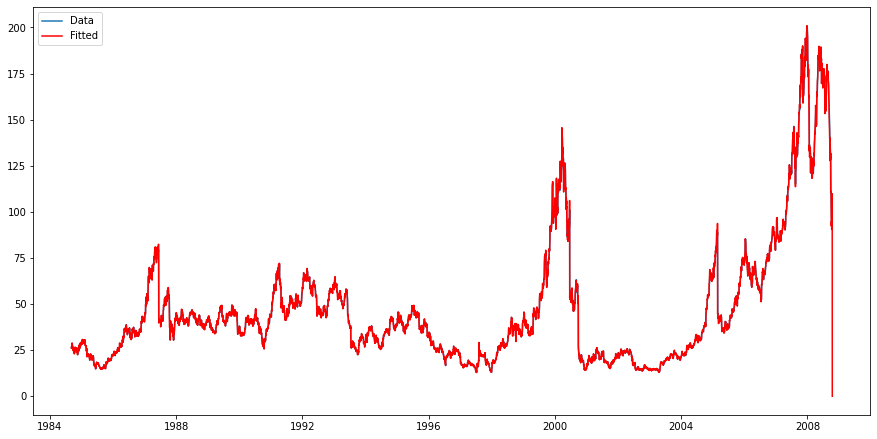

In [ ]:
plt.figure(figsize=[15, 7.5])
plt.plot(df.Date, df.Mean, label='Data')
plt.plot(df.Date, best_model.fittedvalues, color='red', label='Fitted')
plt.legend();

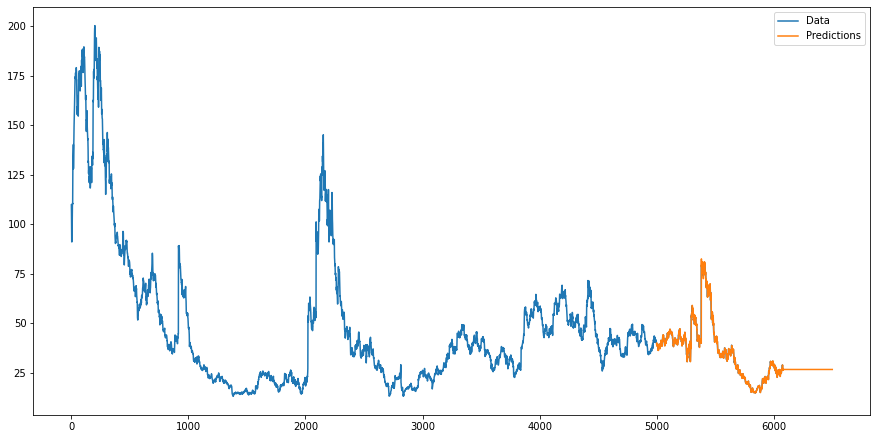

In [ ]:
plt.figure(figsize=[15, 7.5])
plt.plot(df.Mean, label='Data')
plt.plot(best_model.predict(start=5000, end=6500), label='Predictions')
plt.legend();

In [ ]:
from statsmodels.tsa.arima.model import ARIMA
model = ARIMA(np.log(df.Mean), order=(7,1,7))
results = model.fit()

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:963: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:975: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.



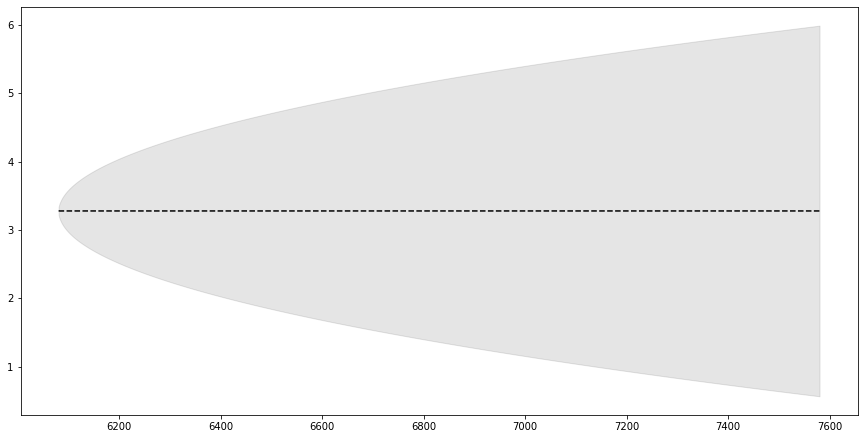

In [ ]:
_, ax = plt.subplots(figsize=(15, 7.5))

fcast = results.get_forecast(steps=1500)
fcast.predicted_mean.plot(ax=ax, style='k--')
yhat_conf_int = fcast.conf_int(alpha=0.05)
ax.fill_between(fcast.row_labels, yhat_conf_int['lower Mean'], yhat_conf_int['upper Mean'], color='k', alpha=0.1);

## 4. Интерпретация

### Автокорреляция

Автокорреляция - способ посмотреть, есть ли внутри наших данных корреляция.
Посмотрим на нее с помощью lag_plot. Возьмем довольно большое значение лага, так как у нас много точек в данных.

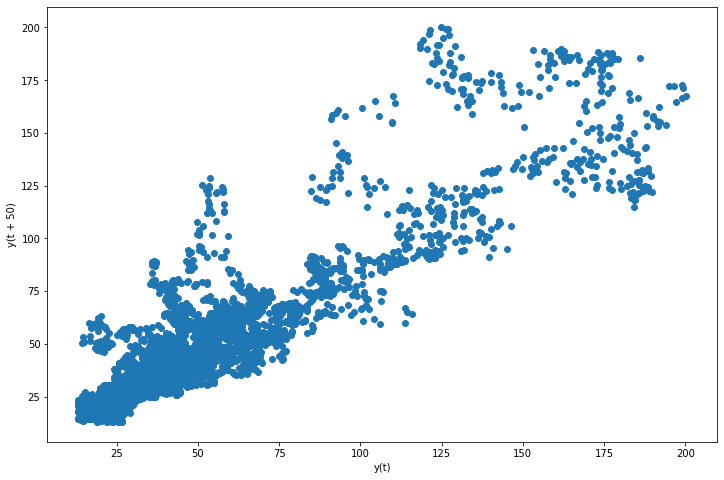

In [ ]:
from pandas.plotting import lag_plot
plt.figure(figsize=(12, 8))
lag_plot(df.Mean, lag=50);

Похоже, есть некоторая корреляция. Можем напрямую измерить коэффициент:

In [ ]:
dataframe = pd.concat([df.Mean.shift(50), df.Mean], axis=1)
dataframe.columns = ['t - 50', 't']
result = dataframe.corr()
print(result)

          t - 50         t
t - 50  1.000000  0.903867
t       0.903867  1.000000


Что, если мы попробуем убрать корреляцию взятием разности?

In [ ]:
diff_data = pd.Series(np.diff(df.Mean))
dataframe = pd.concat([diff_data.shift(50), diff_data], axis=1)
dataframe.columns = ['t - 50', 't']
result = dataframe.corr()
print(result)

         t - 50        t
t - 50  1.00000 -0.00203
t      -0.00203  1.00000


Посмотрим, как изменяется корреляция изначальных данных в зависимости от лага:

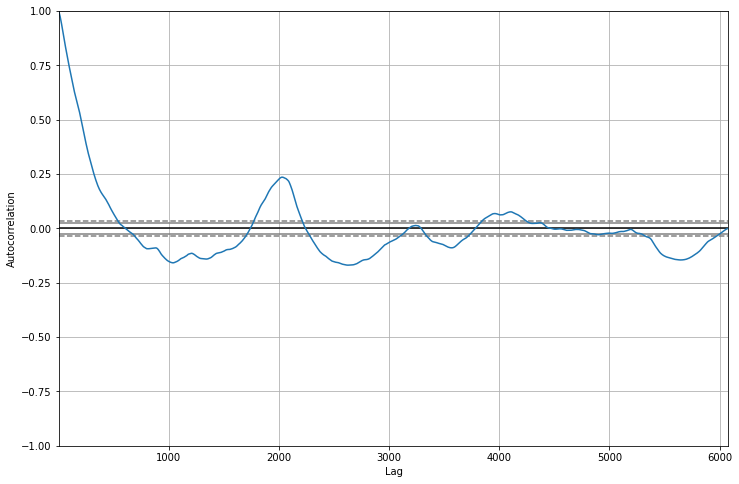

In [ ]:
from pandas.plotting import autocorrelation_plot
plt.figure(figsize=(12, 8))
autocorrelation_plot(df.Mean);